### Visualizing the distribution of the observations

### Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSSBBBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

/Users/gganesan/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12376
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|    10|[80 49 40 4C E0 D...|1949.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     1|[30 54 40 4C A0 D...|1950.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[80 C9 40 4C 40 5...|1951.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[E0 D4 30 D5 F0 D...|1952.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[80 4D 80 4D A0 5...|1953.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [9]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00105980')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

#Query to find the relation between precipitations and snowfall
Query2="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00105980')
print Query
df10 = sqlContext.sql(Query)
print df10.count(),'rows'
df10.show(1)
rows1=df10.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
Test=np.vstack(rows1)
Test=Test/10.  # scaling to make the temperature be in centingrates
print Test.shape

Query3="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNWD','USC00105980')
print Query
df11 = sqlContext.sql(Query)
print df11.count(),'rows'
df11.show(1)
rows2=df11.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
Test=np.vstack(rows1+rows2)
Test=Test/10.  # scaling to make the temperature be in centingrates
shape(Test)






SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00105980'
61 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1269.2| 42.6767|-113.5003|       PRCP|USC00105980|     0|[40 4E 00 45 00 0...|1949.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       PRCP|USC00105980|     0|[00 00 00 49 00 0...|1950.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00105980'
61 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------

(122, 365)

In [ ]:
#Plot for distribution of stations over the state of Idaho

Query="SELECT latitude, longitude, count(station) FROM weather \n\tWHERE measurement='%s' \n\t group by latitude, longitude "%('PRCP')
print Query
df1 = sqlContext.sql(Query)
print df1.show()

### Script for plotting yearly plots

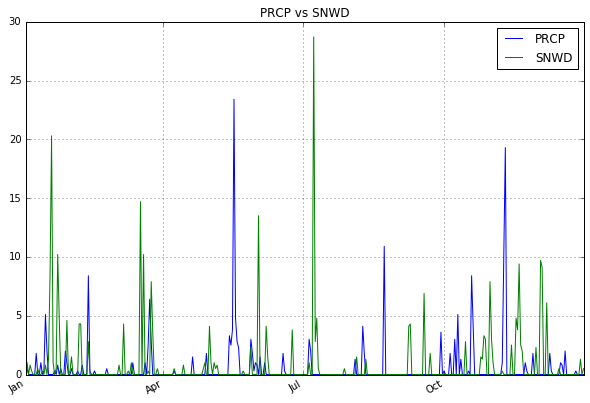

In [15]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(Test[:2,:].transpose(),fig,ax,title="PRCP vs SNWD")
legend(['PRCP','SNWD'])
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [17]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/gganesan/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


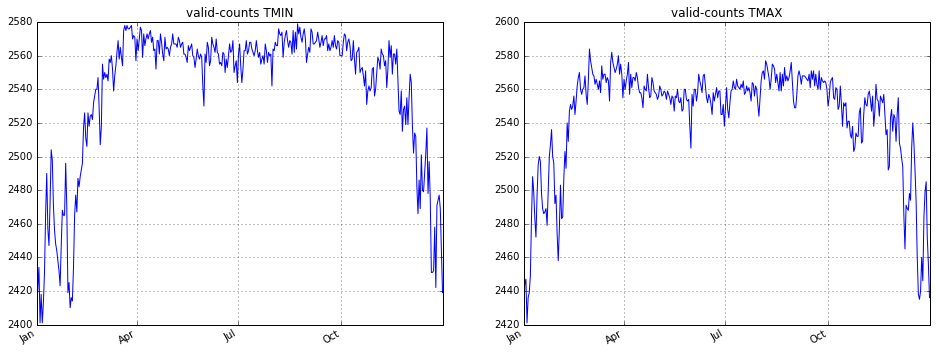

In [18]:
plot_pair(['TMIN','TMAX'],plot_valid)

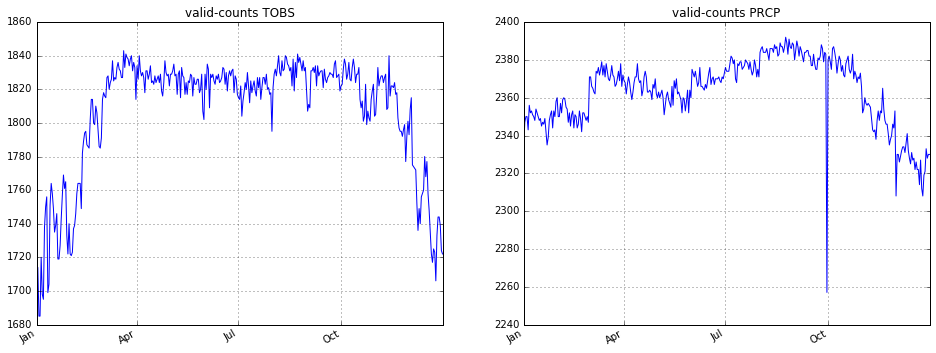

In [19]:
plot_pair(['TOBS','PRCP'],plot_valid)

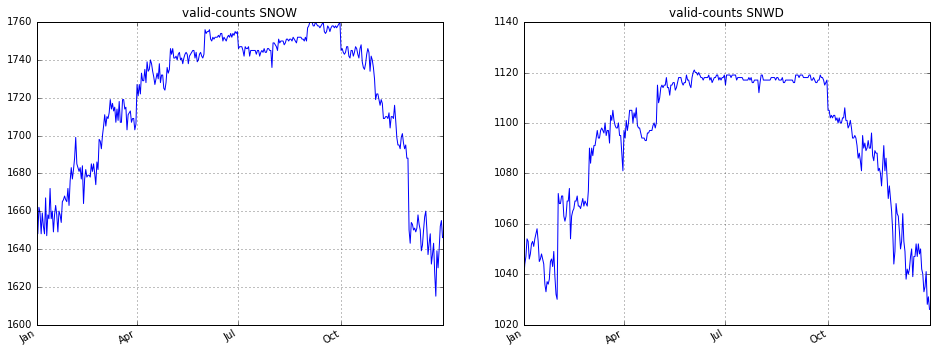

In [20]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [21]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

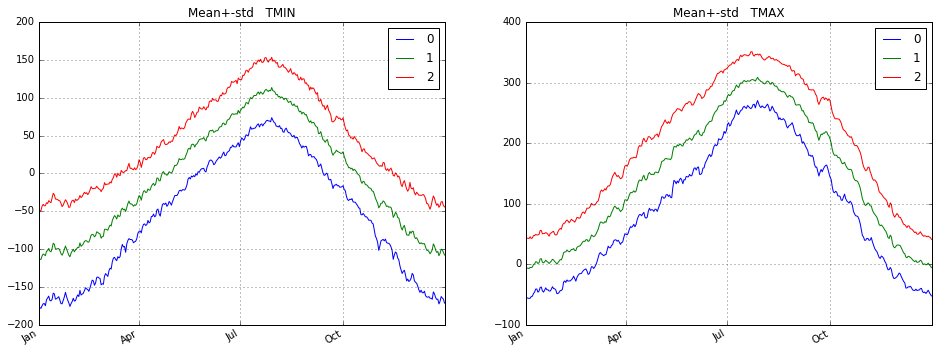

In [22]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

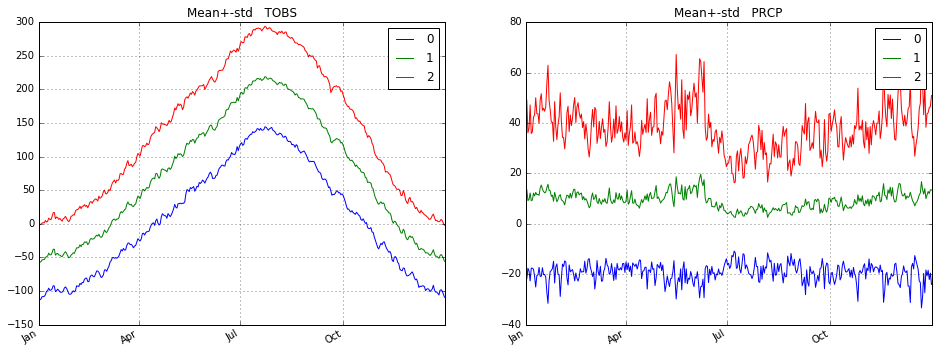

In [23]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

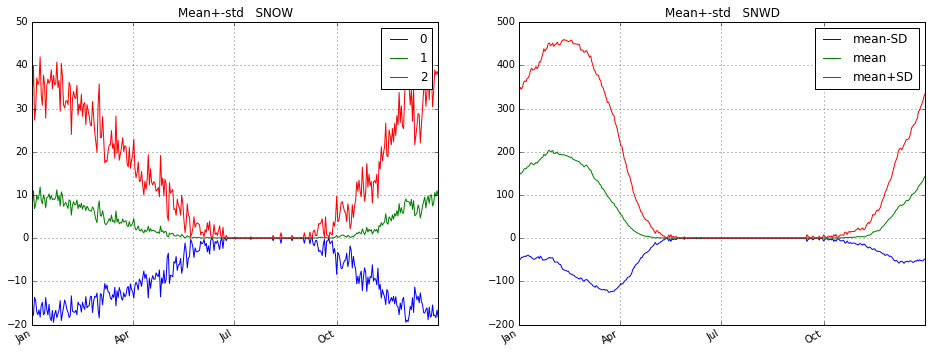

In [24]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)
legend(['mean-SD','mean','mean+SD'])

### plotting top 3 eigenvectors

In [31]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

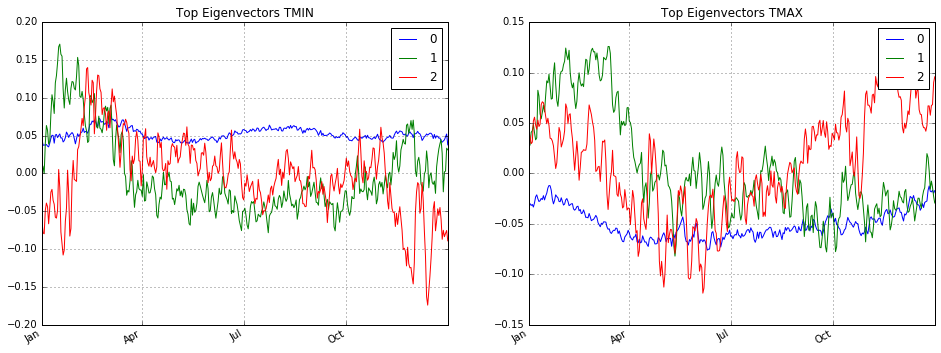

In [32]:
plot_pair(['TMIN','TMAX'],plot_eigen)

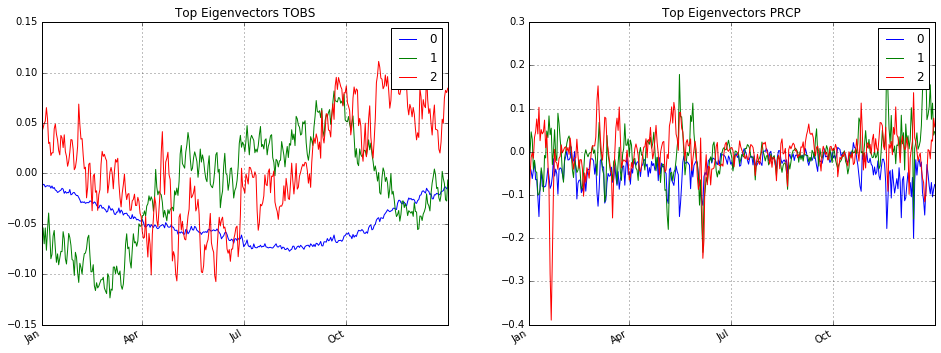

In [33]:
plot_pair(['TOBS','PRCP'],plot_eigen)

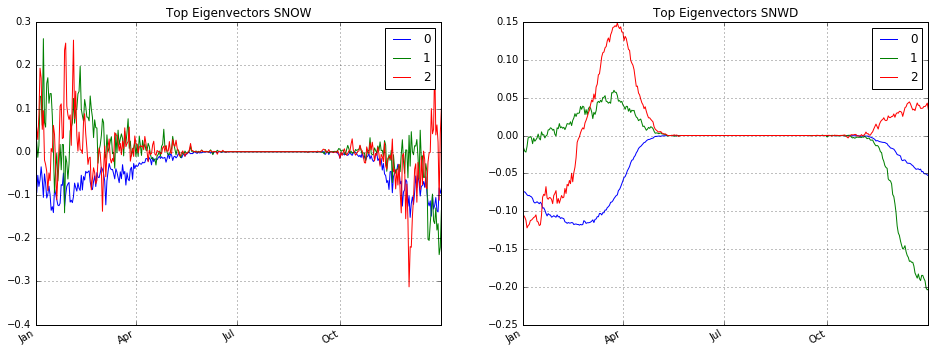

In [34]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [35]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

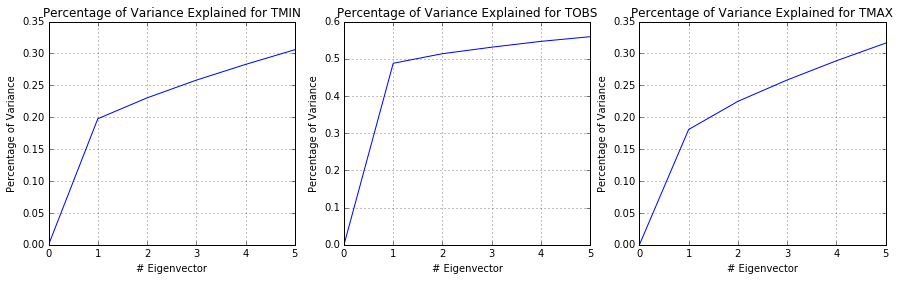

In [36]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

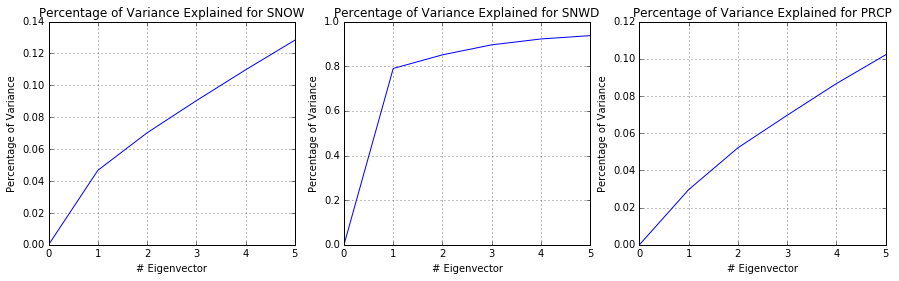

In [37]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [38]:
sc.stop()